##### Copyright 2018 The TensorFlow Authors.
https://www.tensorflow.org/tutorials/images/classification

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 이미지 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼은 꽃 이미지를 분류하는 방법을 보여줍니다. `keras.Sequential` 모델을 사용하여 이미지 분류자를 만들고 `preprocessing.image_dataset_from_directory`를 사용하여 데이터를 로드합니다. 이를 통해 다음 개념을 실제로 경험해 볼 수 있습니다.

- 디스크에서 데이터세트를 효율적으로 로드합니다.
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용합니다.

이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.

1. 데이터 검사 및 이해하기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기

In [1]:
#!pip install -q tf-nightly

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'd:\\program\\python\\python37\\lib\\site-packages\\~5py\\defs.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'd:\program\python\python37\python.exe -m pip install --upgrade pip' command.


## TensorFlow 및 기타 라이브러리 가져오기

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터세트 다운로드 및 탐색하기

이 튜토리얼에서는 약 3,700장의 꽃 사진 데이터세트를 사용합니다. 데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 3,670개의 이미지가 있습니다.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


다음은 몇 가지 장미입니다.

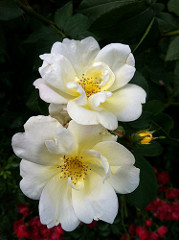

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

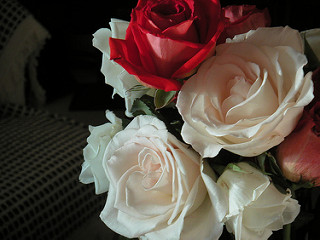

In [5]:
PIL.Image.open(str(roses[1]))

그리고 일부 튤립이 있습니다.

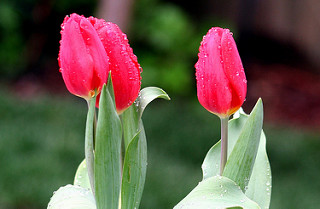

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

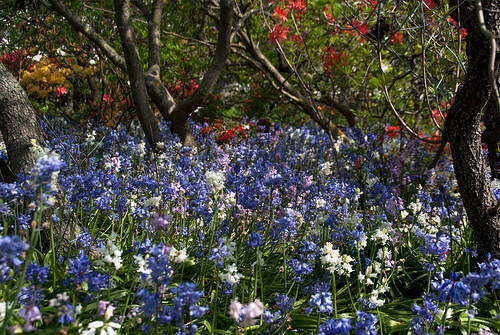

In [8]:
PIL.Image.open(str(tulips[1]))

# keras.preprocessing을 사용하여 로드하기

유용한 [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 유틸리티를 사용하여 이러한 이미지를 디스크에서 로드하겠습니다. 몇 줄의 코드만으로 디스크의 이미지 디렉토리가 `tf.data.Dataset`로 가져와 집니다. 원하는 경우, [이미지 로드](https://www.tensorflow.org/tutorials/load_data/images) 튜토리얼을 방문하여 데이터 로드 코드를 처음부터 직접 작성할 수도 있습니다.

## 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [6]:
import tensorflow_datasets as tfds

train_images = tfds.as_numpy(train_ds)
print(train_images)

## 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

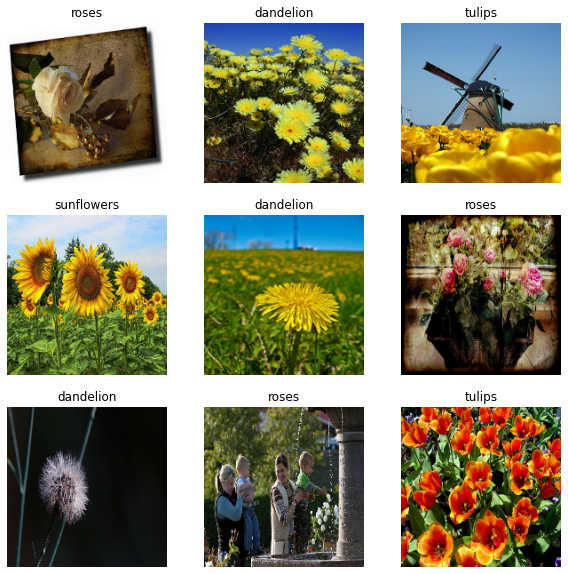

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

잠시 후에 이들 데이터세트를 `model.fit`에 전달하여 모델을 훈련하겠습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


## 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

`Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`Dataset.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 방법과 디스크에 데이터를 캐싱하는 방법에 대해 자세히 알아볼 수 있습니다.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

참고: 이 섹션에서 소개하는 Keras Preprocesing 유틸리티와 레이어는 현재 실험적 단계이며 변경될 수 있습니다.

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [크기 조정](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 사용할 수 있습니다.

# 모델 만들기

모델은 각각에 최대 풀 레이어가 있는 3개의 컨볼루션 블록으로 구성됩니다. 그 위에 `relu` 활성화 함수에 의해 활성화되는 128개의 단위가 있는 완전히 연결된 레이어가 있습니다. 이 모델은 높은 정확성을 고려해 조정되지 않았습니다. 이 튜토리얼의 목표는 표준적인 접근법을 보여주는 것입니다. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일하기

이 튜토리얼에서는 `optimizers.Adam` 옵티마이저 및 `losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확성을 보려면 `metrics` 인수를 전달합니다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 요약

모델의 `summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## 모델 훈련하기

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 103s 1s/step - loss: 1.5579 - accuracy: 0.3551 - val_loss: 1.1218 - val_accuracy: 0.5300
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 1.0252 - accuracy: 0.6052 - val_loss: 0.9956 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 102s 1s/step - loss: 0.8071 - accuracy: 0.6992 - val_loss: 0.8915 - val_accuracy: 0.6567
Epoch 4/10
92/92 [==============================] - 100s 1s/step - loss: 0.6041 - accuracy: 0.7765 - val_loss: 0.9120 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 102s 1s/step - loss: 0.3942 - accuracy: 0.8721 - val_loss: 0.9663 - val_accuracy: 0.6594
Epoch 6/10
92/92 [==============================] - 100s 1s/step - loss: 0.2230 - accuracy: 0.9233 - val_loss: 1.1612 - val_accuracy: 0.6567
Epoch 7/10
92/92 [==============================] - 101s 1s/step - loss: 0.1124 - accuracy: 0.9674 - val_loss: 1.2899 - val_accuracy: 0.6444
Epoch 8/10
92

## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

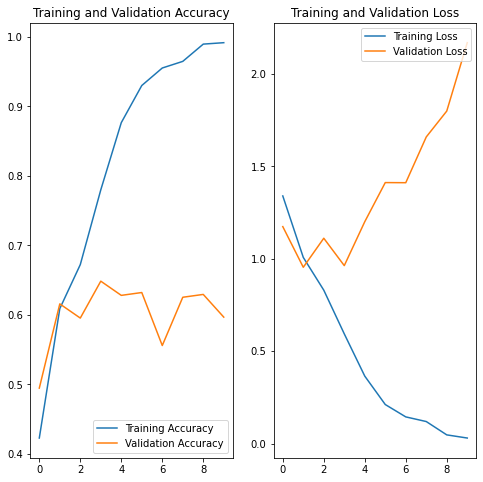

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯에서 볼 수 있듯이 훈련 정확성과 검증 정확성은 큰 차이가 있으며, 모델은 검증 세트에서 약 60%의 정확성까지만 도달합니다.

무엇이 잘못되었는지 살펴보고 모델의 전반적인 성능을 향상해 보겠습니다.

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.

훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 *데이터 증강*을 사용하고 모델에 *드롭아웃*을 추가합니다.

## 데이터 증강

과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. [데이터 증강](https://www.tensorflow.org/tutorials/images/data_augmentation)은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

여기서는 실험적인 [Keras 전처리 레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly)를 사용하여 데이터 증강을 구현합니다. 이들 레이어는 다른 레이어와 마찬가지로 모델 내에 포함될 수 있으며, GPU에서 실행됩니다.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강된 예제가 어떻게 보이는지 시각화하겠습니다.

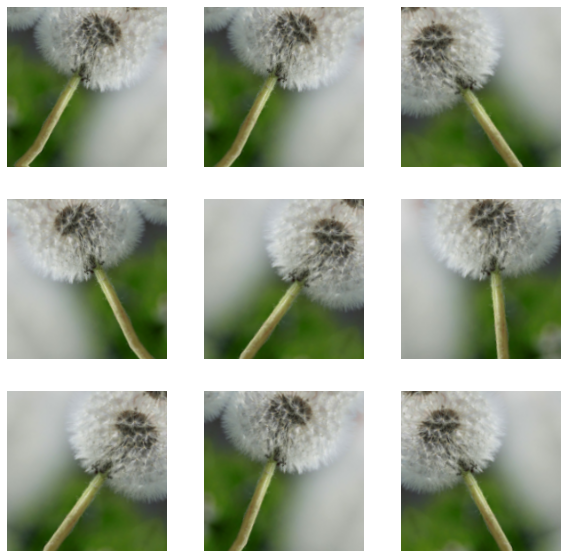

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

잠시 후에 데이터 증강을 사용하여 모델을 훈련하겠습니다.

## 드롭아웃

과대적합을 줄이는 또 다른 기술은 *정규화*의 한 형태인 [드롭아웃](https://developers.google.com/machine-learning/glossary#dropout_regularization)을 네트워크에 도입하는 것입니다.

드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정). 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다. 이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.

`layers.Dropout`을 사용하여 새로운 신경망을 생성한 다음, 증강 이미지를 사용하여 훈련해 보겠습니다.

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일 및 훈련하기

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 2s 15ms/step - loss: 1.4985 - accuracy: 0.3295 - val_loss: 1.0878 - val_accuracy: 0.5668
Epoch 2/15
92/92 [==============================] - 1s 14ms/step - loss: 1.0451 - accuracy: 0.5938 - val_loss: 1.0181 - val_accuracy: 0.6117
Epoch 3/15
92/92 [==============================] - 1s 14ms/step - loss: 0.9113 - accuracy: 0.6496 - val_loss: 0.9383 - val_accuracy: 0.6294
Epoch 4/15
92/92 [==============================] - 1s 14ms/step - loss: 0.8675 - accuracy: 0.6637 - val_loss: 0.9306 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 1s 14ms/step - loss: 0.7853 - accuracy: 0.6964 - val_loss: 0.7701 - val_accuracy: 0.7016
Epoch 6/15
92/92 [==============================] - 1s 14ms/step - loss: 0.7838 - accuracy: 0.6994 - val_loss: 0.8100 - val_accuracy: 0.6880
Epoch 7/15
92/92 [==============================] - 1s 14ms/step - loss: 0.6774 - accuracy: 0.7359 - val_loss: 0.7858 - val_accuracy: 0.6744
Epoch 8/15
92

## 훈련 결과 시각화하기

데이터 증강 및 드롭아웃을 적용한 후, 이전보다 과대적합이 줄어들고 훈련 및 검증 정확성이 더 가깝게 조정됩니다. 

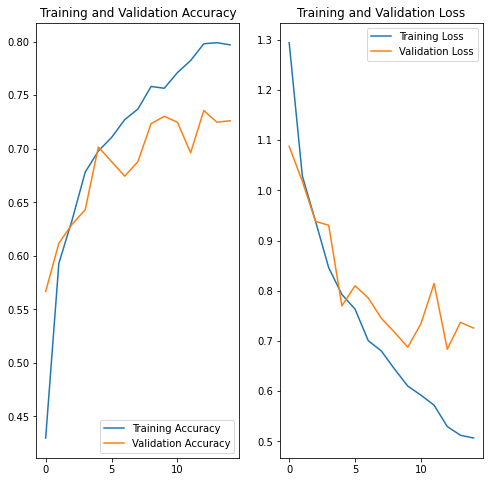

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측하기

마지막으로, 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류해 보겠습니다.

참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 98.55 percent confidence.
